In [29]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit
import re, copy

SEASON_SPLIT = 2024

## Reading in data from csv files

In [30]:
matches = pd.read_csv('matches.csv', index_col=0)
print(matches.shape)

(2955, 40)


In [31]:
next_matches = pd.read_csv('next_matches.csv', index_col=0)
print(next_matches.shape)

(20, 22)


In [32]:
history_matches = pd.read_csv('history.csv', index_col=0)
print(history_matches.shape)

(44647, 16)


In [33]:
# getting the matches of the desired league
LEAGUE = 'Premier League'
league_matches = matches[matches['Comp'] == LEAGUE]
league_matches.head()

,Date,Time,Comp,Round,Day,Venue,Result,GF,GA,Opponent,...,2CrdY,Fls,Fld,Off,Crs,Int,TklW,Won%,SCA,GCA
1,2025-08-15,20:00 (05:00),Premier League,Matchweek 1,Fri,Home,W,4,2,Bournemouth,...,0.0,7.0,10.0,2.0,17.0,4.0,13.0,61.7,36.0,7.0
2,2025-08-25,20:00 (05:00),Premier League,Matchweek 2,Mon,Away,W,3,2,Newcastle Utd,...,0.0,15.0,16.0,0.0,9.0,0.0,8.0,51.5,9.0,6.0
3,2025-08-31,16:30 (01:30),Premier League,Matchweek 3,Sun,Home,W,1,0,Arsenal,...,0.0,7.0,10.0,1.0,7.0,7.0,9.0,55.6,16.0,2.0
4,2025-08-17,14:00 (23:00),Premier League,Matchweek 1,Sun,Home,D,0,0,Crystal Palace,...,0.0,10.0,10.0,0.0,29.0,11.0,6.0,51.5,31.0,0.0
5,2025-08-22,20:00 (05:00),Premier League,Matchweek 2,Fri,Away,W,5,1,West Ham,...,0.0,10.0,7.0,2.0,15.0,4.0,13.0,51.7,20.0,9.0


## Date Exploration and Analysis

In [34]:
league_matches['Team'].value_counts()

Team
Liverpool                   117
Chelsea                     117
Arsenal                     117
Tottenham Hotspur           117
Everton                     117
Bournemouth                 117
Crystal Palace              117
Manchester United           117
Nottingham Forest           117
Wolverhampton Wanderers     117
Brighton and Hove Albion    117
Manchester City             117
Brentford                   117
Newcastle United            117
West Ham United             117
Aston Villa                 117
Fulham                      117
Southampton                  76
Leicester City               76
Burnley                      41
Leeds United                 41
Luton Town                   38
Ipswich Town                 38
Sheffield United             38
Sunderland                    3
Name: count, dtype: int64

In [35]:
league_matches['Opponent'].value_counts()

Opponent
Bournemouth        117
Newcastle Utd      117
Arsenal            117
Crystal Palace     117
West Ham           117
Fulham             117
Manchester Utd     117
Liverpool          117
Manchester City    117
Everton            117
Brighton           117
Wolves             117
Brentford          117
Chelsea            117
Tottenham          117
Nott'ham Forest    117
Aston Villa        117
Southampton         76
Leicester City      76
Leeds United        41
Burnley             41
Sheffield Utd       38
Ipswich Town        38
Luton Town          38
Sunderland           3
Name: count, dtype: int64

In [36]:
league_matches.dtypes

Date              object
Time              object
Comp              object
Round             object
Day               object
Venue             object
Result            object
GF                object
GA                object
Opponent          object
xG               float64
xGA              float64
Poss             float64
Attendance       float64
Captain           object
Formation         object
Opp Formation     object
Referee           object
Match Report      object
Notes             object
Season             int64
Team              object
Sh               float64
SoT              float64
Dist             float64
FK               float64
PK               float64
PKatt            float64
CrdY             float64
CrdR             float64
2CrdY            float64
Fls              float64
Fld              float64
Off              float64
Crs              float64
Int              float64
TklW             float64
Won%             float64
SCA              float64
GCA              float64


In [37]:
team_names = sorted(league_matches['Team'].unique())
opp_names = sorted(league_matches['Opponent'].unique())

exculsive_team_names = []
exculsive_opp_names = []

# finding out the team names that are written differently in the opponent column
for i in team_names:
    if (i not in opp_names):
        exculsive_team_names.append(i)
        print(i)

print('---------------------------')

for i in opp_names:
    if (i not in team_names):
        exculsive_opp_names.append(i)
        print(i)

Brighton and Hove Albion
Manchester United
Newcastle United
Nottingham Forest
Sheffield United
Tottenham Hotspur
West Ham United
Wolverhampton Wanderers
---------------------------
Brighton
Manchester Utd
Newcastle Utd
Nott'ham Forest
Sheffield Utd
Tottenham
West Ham
Wolves


In [38]:
# creating class to map team names written differently in opponent column to 
# corresponding team names.
class MissingDict(dict):
    __missing__ = lambda self, key: key

map_values = {}

for team_name, opp_name in zip(exculsive_team_names, exculsive_opp_names):
    map_values[team_name] = opp_name

mapping = MissingDict(**map_values)

In [39]:
# applying mapping to ensure consistent team names
matches['Team'] = matches['Team'].map(mapping)
# creating a dictionary of team codes to ensure consistent team codes for each
# team
team_mapping_dict = {key: value for key, value in zip(matches['Team'], matches['Team'].astype('category').cat.codes)}
matches['Team_code'] = matches['Team'].map(team_mapping_dict)
matches['Opp_code'] = matches['Opponent'].map(team_mapping_dict)

# simplifying date and venue into respective codes
matches['Date'] = pd.to_datetime(matches['Date'])
matches['Venue_code'] = matches['Venue'].astype('category').cat.codes
matches['Hour'] = matches['Time'].str.replace(":.+", "", regex=True).astype('int')
matches['Day_code'] = matches['Date'].dt.dayofweek

matches['Target'] = matches['Result'].astype('category').cat.codes

matches['GF'] = matches['GF'].apply(lambda x: int(re.search(r'^[0-9]+', x).group(0)))
matches['GA'] = matches['GA'].apply(lambda x: int(re.search(r'^[0-9]+', str(x)).group(0)))

In [40]:
matches = matches.drop(columns=['Time', 'Day', 'Venue', 'Result', 'Attendance',
                                'Match Report', 'Notes','Captain', 'Formation',
                                'Opp Formation', 'Referee'])

In [41]:
matches.dtypes

Date          datetime64[ns]
Comp                  object
Round                 object
GF                     int64
GA                     int64
Opponent              object
xG                   float64
xGA                  float64
Poss                 float64
Season                 int64
Team                  object
Sh                   float64
SoT                  float64
Dist                 float64
FK                   float64
PK                   float64
PKatt                float64
CrdY                 float64
CrdR                 float64
2CrdY                float64
Fls                  float64
Fld                  float64
Off                  float64
Crs                  float64
Int                  float64
TklW                 float64
Won%                 float64
SCA                  float64
GCA                  float64
Team_code              int64
Opp_code             float64
Venue_code              int8
Hour                   int64
Day_code               int32
Target        

In [42]:
matches['Target'].value_counts()

Target
2    1253
1    1057
0     645
Name: count, dtype: int64

In [43]:
next_matches['Team'] = next_matches['Team'].map(mapping)
next_matches['Team_code'] = next_matches['Team'].map(team_mapping_dict)
next_matches['Opp_code'] = next_matches['Opponent'].map(team_mapping_dict)

next_matches['Date'] = pd.to_datetime(next_matches['Date'])
next_matches['Venue_code'] = next_matches['Venue'].astype('category').cat.codes
next_matches['Hour'] = next_matches['Time'].str.replace(":.+", "", regex=True).astype('int')
next_matches['Day_code'] = next_matches['Date'].dt.dayofweek

In [44]:
next_matches = next_matches.drop(columns=['Time', 'Day', 'Venue', 'Result', 
                                          'Attendance', 'Match Report', 'Notes',
                                          'Captain', 'Formation',
                                          'Opp Formation', 'Referee'])

In [45]:
next_matches.dtypes

Date          datetime64[ns]
Comp                  object
Round                 object
GF                   float64
GA                   float64
Opponent              object
xG                   float64
xGA                  float64
Poss                 float64
Season                 int64
Team                  object
Team_code              int64
Opp_code               int64
Venue_code              int8
Hour                   int64
Day_code               int32
dtype: object

In [59]:
def get_Target(row):
    if row['GF'] > row['GA']:
        return 2
    elif row['GF'] < row['GA']:
        return 1
    else:
        return 0

In [60]:
history_matches['Team'] = history_matches['Team'].map(mapping)
history_matches['Date'] = pd.to_datetime(history_matches['Date'])
history_matches['GF'] = history_matches['Score'].apply(lambda score: (score.split('–')[0]))
history_matches['GA'] = history_matches['Score'].apply(lambda score: score.split('–')[1])
history_matches['GF'] = history_matches['GF'].apply(lambda x: int(re.search(r'[0-9]+$', x).group(0)))
history_matches['GA'] = history_matches['GA'].apply(lambda x: int(re.search(r'^[0-9]+', x).group(0)))
history_matches['Target'] = history_matches.apply(get_Target, axis=1)

In [47]:
history_matches = history_matches.drop(columns=['Time', 'Day', 'Venue', 
                                                'Attendance', 'Match Report', 
                                                'Notes', 'Referee',
                                                'Home', 'Away'])

In [61]:
history_matches.dtypes

Comp              object
Round             object
Date      datetime64[ns]
xG               float64
Score             object
xG.1             float64
Team              object
GF                 int64
GA                 int64
Target             int64
dtype: object

In [62]:
history_matches.head()

,Comp,Round,Date,xG,Score,xG.1,Team,GF,GA,Target
0,Premier League,Premier League,2023-04-17,1.4,1–6,2.7,Liverpool,1,6,1
1,Premier League,Premier League,2022-10-29,1.7,1–2,1.8,Liverpool,1,2,1
2,Premier League,Premier League,2022-02-23,5.9,6–0,0.2,Liverpool,6,0,2
3,Premier League,Premier League,2021-09-12,1.2,0–3,4.3,Liverpool,0,3,1
4,Premier League,Premier League,2021-04-19,2.3,1–1,1.4,Liverpool,1,1,0


In [50]:
# function to compute rolling averages of given columns for each match
def rolling_avgs(group, cols, new_cols, num_past_matches_considered=3):
    group = group.sort_values('Date')
    rolling_stats = group[cols].rolling(num_past_matches_considered, 
                                        closed='left', min_periods=1).mean()
    group[new_cols] = rolling_stats.fillna(0)
    return group

In [51]:
# rolling avgs for matches across the desired league
league_ravg_cols = ['GF', 'GA', 'Sh', 'SoT', 'Dist', 'FK', 'PK', 'PKatt', 'CrdY', 
             'CrdR', '2CrdY', 'Fls', 'Fld', 'Off', 'Crs', 'Int', 'TklW', 'Won%',
             'SCA', 'GCA', 'xG', 'xGA']
league_ravg_new_cols = [f"{c}league_rolling" for c in league_ravg_cols]

In [52]:
# stats for last match
last_ravg_cols = ['GF', 'GA', 'Sh', 'SoT', 'Dist', 'FK', 'PK', 'PKatt', 'CrdY', 
             'CrdR', '2CrdY', 'Fls', 'Fld', 'Off', 'Crs', 'Int', 'TklW', 'Won%',
             'SCA', 'GCA', 'xG', 'xGA', 'Target']
last_ravg_new_cols = [f"{c}last_rolling" for c in last_ravg_cols]

In [53]:
# rolling avgs for matches across all head to head matches
hth_ravg_cols = ['xG', 'xG.1', 'GF', 'GA']
hth_ravg_new_cols = [f"{c}hth_rolling" for c in hth_ravg_cols]

In [54]:
def rolling_avg_match_rest(group, num_past_matches_considered=3):
    group['days_diff'] = group['Date'].diff().dt.days
    rolling_stats = group['days_diff'].rolling(num_past_matches_considered, 
                                        closed='left', min_periods=1).mean()
    group[f'rolling_rests_{num_past_matches_considered}'] = rolling_stats.fillna(0)
    return group

In [69]:
def rolling_match_results(group, name, num_past_matches_considered=3):
    group['is_win'] = (group['Target'] == 2).astype(int)
    rolling_stats = group['is_win'].rolling(num_past_matches_considered, 
                                        closed='left', min_periods=1).sum()
    group[f'{name}num_wins_rolling'] = rolling_stats.fillna(0)
    return group

In [114]:
all_matches = pd.concat([matches, next_matches])
all_matches = all_matches.groupby('Team', group_keys=True).apply(lambda x: rolling_avg_match_rest(x),
                                                                         include_groups=False).reset_index(level=0).reset_index(drop=True)
league_matches = all_matches[all_matches['Comp'] == LEAGUE]
team_league_matches = league_matches.groupby('Team', group_keys=True).apply(lambda x: rolling_avgs(x, league_ravg_cols, league_ravg_new_cols),
                                                                         include_groups=False).reset_index(level=0).reset_index(drop=True)
team_league_matches = team_league_matches.groupby('Team', group_keys=True).apply(lambda x: rolling_match_results(x, 'league'),
                                                                         include_groups=False).reset_index(level=0).reset_index(drop=True)
# team_matches = team_matches.droplevel('Team')
# team_matches.index = range(team_matches.shape[0])
team_last_matches = all_matches.groupby('Team', group_keys=True).apply(lambda x: rolling_avg_match_rest(x,1),
                                                                         include_groups=False).reset_index(level=0).reset_index(drop=True)
team_last_matches = team_last_matches.groupby('Team', group_keys=True).apply(lambda x: rolling_avgs(x, last_ravg_cols, last_ravg_new_cols,1),
                                                                         include_groups=False).reset_index(level=0).reset_index(drop=True)
hth_and_next_matches = pd.concat([history_matches, next_matches])
team_hth_matches = hth_and_next_matches.groupby('Team', group_keys=True).apply(lambda x: rolling_avgs(x, hth_ravg_cols, hth_ravg_new_cols),
                                                                               include_groups=False).reset_index(level=0).reset_index(drop=True)

team_hth_matches = team_hth_matches.groupby('Team', group_keys=True).apply(lambda x: rolling_match_results(x, 'hth'),
                                                                               include_groups=False).reset_index(level=0).reset_index(drop=True)


In [115]:
opp_team_league_matches = team_league_matches.copy()
opp_team_league_matches = opp_team_league_matches.add_prefix('Opp_')

opp_team_last_matches = team_last_matches.copy()
opp_team_last_matches = opp_team_last_matches.add_prefix('Opp_')

In [116]:
team_league_matches = team_league_matches.merge(opp_team_league_matches,
                                         left_on=['Date', 'Opponent'],
                                         right_on=['Opp_Date', 'Opp_Team'],
                                         how='left')
team_league_matches = team_league_matches.drop(columns=['Opp_Date', 'Opp_Team', 'Opp_Comp', 'Opp_Round',
                                  'Opp_GF', 'Opp_GA', 'Opp_Opponent','Opp_xG',
                                  'Opp_xGA', 'Opp_Season', 'Opp_Team_code', 'Opp_Opp_code',
                                  'Opp_Venue_code', 'Opp_Hour', 'Opp_Day_code',
                                  'Opp_Target', 'Opp_days_diff', 'Opp_is_win'])
team_last_matches = team_last_matches.merge(opp_team_last_matches,
                                         left_on=['Date', 'Opponent'],
                                         right_on=['Opp_Date', 'Opp_Team'],
                                         how='left')
team_last_matches = team_last_matches.drop(columns=['Opp_Date', 'Opp_Team', 'Opp_Comp', 'Opp_Round',
                                  'Opp_GF', 'Opp_GA', 'Opp_Opponent','Opp_xG',
                                  'Opp_xGA', 'Opp_Season', 'Opp_Team_code', 'Opp_Opp_code',
                                  'Opp_Venue_code', 'Opp_Hour', 'Opp_Day_code',
                                  'Opp_days_diff'])

In [117]:
last_ravg_new_cols_merge = copy.deepcopy(last_ravg_new_cols)
hth_ravg_new_cols_merge = copy.deepcopy(hth_ravg_new_cols)
last_ravg_new_cols_merge = last_ravg_new_cols_merge + ['Opp_' + column for column in last_ravg_new_cols_merge]
last_ravg_new_cols_merge.append('Date')
hth_ravg_new_cols_merge.append('Date')
last_ravg_new_cols_merge.append('Team')
hth_ravg_new_cols_merge.append('Team')
last_ravg_new_cols_merge.append('rolling_rests_1')
last_ravg_new_cols_merge.append('Opp_rolling_rests_1')
hth_ravg_new_cols_merge.append('hthnum_wins_rolling')
team_matches = team_league_matches.merge(team_last_matches[last_ravg_new_cols_merge],
                                                on=['Date', 'Team'], how='left')
team_matches = team_matches.merge(team_hth_matches[hth_ravg_new_cols_merge],
                                                on=['Date', 'Team'], how='left')

In [118]:
team_matches = team_matches[team_matches['Comp'] == LEAGUE]

In [120]:
team_matches.shape

(2360, 157)

In [122]:
print(list(team_matches.columns))

['Team', 'Date', 'Comp', 'Round', 'GF', 'GA', 'Opponent', 'xG', 'xGA', 'Poss', 'Season', 'Sh', 'SoT', 'Dist', 'FK', 'PK', 'PKatt', 'CrdY', 'CrdR', '2CrdY', 'Fls', 'Fld', 'Off', 'Crs', 'Int', 'TklW', 'Won%', 'SCA', 'GCA', 'Team_code', 'Opp_code', 'Venue_code', 'Hour', 'Day_code', 'Target', 'days_diff', 'rolling_rests_3', 'GFleague_rolling', 'GAleague_rolling', 'Shleague_rolling', 'SoTleague_rolling', 'Distleague_rolling', 'FKleague_rolling', 'PKleague_rolling', 'PKattleague_rolling', 'CrdYleague_rolling', 'CrdRleague_rolling', '2CrdYleague_rolling', 'Flsleague_rolling', 'Fldleague_rolling', 'Offleague_rolling', 'Crsleague_rolling', 'Intleague_rolling', 'TklWleague_rolling', 'Won%league_rolling', 'SCAleague_rolling', 'GCAleague_rolling', 'xGleague_rolling', 'xGAleague_rolling', 'is_win', 'leaguenum_wins_rolling', 'Opp_Poss', 'Opp_Sh', 'Opp_SoT', 'Opp_Dist', 'Opp_FK', 'Opp_PK', 'Opp_PKatt', 'Opp_CrdY', 'Opp_CrdR', 'Opp_2CrdY', 'Opp_Fls', 'Opp_Fld', 'Opp_Off', 'Opp_Crs', 'Opp_Int', 'Opp_Tk

In [123]:
sorted_round = sorted(team_matches['Round'].unique(), key=lambda round:int((re.search('[0-9]+$', round)).group(0)))
round_mapping_dict = {value: key for key, value in enumerate(sorted_round, start=1)}
team_matches['Round'] = team_matches['Round'].map(round_mapping_dict)

In [124]:
# add ranking of the teams at each match
from collections import defaultdict

team_matches = team_matches.sort_values('Date').reset_index(drop=True)

curr_season = 0
for season_gameweek, stats in team_matches.groupby(['Season', 'Round'], sort=True):
    if curr_season != season_gameweek[0]:
        curr_season = season_gameweek[0]
        standings = defaultdict(lambda : {'points': 0, 'goal_diff': 0, 'GF': 0})

    sorted_standings = sorted(standings.items(), 
                              key=lambda x: (-x[1]['points'], -x[1]['goal_diff'], -x[1]['GF'], x[0]))
    ranking = {team: pos for pos, (team, stats) in enumerate(sorted_standings, start=1)}
    
    # setting current league position
    for index, row in stats.iterrows():
        team_matches.at[index, 'Team_position'] = ranking.get(row['Team'], 0)
        team_matches.at[index, 'Opp_position'] = ranking.get(row['Opponent'], 0)

    # updating ranking data
    for index, row in stats.iterrows():
        goals_for = row['GF']
        goals_against = row['GA']
        standings[row['Team']]['GF'] += goals_for
        standings[row['Team']]['goal_diff'] += goals_for - goals_against
        
        if goals_for > goals_against:
            standings[row['Team']]['points'] += 3
        elif goals_for < goals_against:
            standings[row['Team']]['points'] += 0
        else:
            standings[row['Team']]['points'] += 1

team_matches

,Team,Date,Comp,Round,GF,GA,Opponent,xG,xGA,Poss,...,Opp_Targetlast_rolling,rolling_rests_1,Opp_rolling_rests_1,xGhth_rolling,xG.1hth_rolling,GFhth_rolling,GAhth_rolling,hthnum_wins_rolling,Team_position,Opp_position
0,Arsenal,2022-08-05,Premier League,1,2.0,0.0,Crystal Palace,1.0,1.2,44.0,...,0.0,7.0,8.0,2.833333,0.733333,3.333333,0.333333,3.0,0.0,0.0
1,Crystal Palace,2022-08-05,Premier League,1,0.0,2.0,Arsenal,1.2,1.0,56.0,...,0.0,8.0,7.0,0.800000,1.066667,1.666667,1.000000,2.0,0.0,0.0
2,Southampton,2022-08-06,Premier League,1,1.0,4.0,Tottenham,0.5,1.5,42.0,...,0.0,7.0,5.0,2.033333,1.266667,2.666667,1.000000,2.0,0.0,0.0
3,Aston Villa,2022-08-06,Premier League,1,0.0,2.0,Bournemouth,0.7,0.6,65.0,...,0.0,6.0,8.0,1.966667,1.066667,1.666667,1.333333,1.0,0.0,0.0
4,Liverpool,2022-08-06,Premier League,1,2.0,2.0,Fulham,1.2,1.2,67.0,...,0.0,-659.0,8.0,2.450000,1.100000,2.000000,1.000000,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2355,Wolves,2025-09-13,Premier League,4,NaN,NaN,Newcastle Utd,NaN,NaN,NaN,...,0.0,8.0,6.0,1.200000,1.200000,2.000000,1.666667,2.0,20.0,17.0
2356,Burnley,2025-09-14,Premier League,4,NaN,NaN,Liverpool,NaN,NaN,NaN,...,2.0,8.0,8.0,2.300000,1.000000,2.333333,1.000000,3.0,14.0,1.0
2357,Liverpool,2025-09-14,Premier League,4,NaN,NaN,Burnley,NaN,NaN,NaN,...,1.0,8.0,8.0,1.233333,0.966667,2.333333,1.666667,2.0,1.0,14.0
2358,Manchester City,2025-09-14,Premier League,4,NaN,NaN,Manchester Utd,NaN,NaN,NaN,...,2.0,7.0,6.0,1.466667,1.766667,0.666667,2.333333,1.0,13.0,9.0


In [60]:
team_matches.to_csv('new.csv')

In [125]:
team_matches['Match_key'] = team_matches.apply(lambda row: tuple(sorted([row['Team'], row['Opponent']])), axis=1)

team_matches = team_matches.drop_duplicates(subset=['Match_key', 'Date'])
team_matches = team_matches.drop(columns=['Match_key'])

In [126]:
team_matches.shape

(1180, 159)

In [127]:
team_matches['GF_league_rolling_diff'] = team_matches['GFleague_rolling'] - team_matches['Opp_GFleague_rolling']
team_matches['GA_league_rolling_diff'] = team_matches['GAleague_rolling'] - team_matches['Opp_GAleague_rolling']
team_matches['xG_league_rolling_diff'] = team_matches['xGleague_rolling'] - team_matches['Opp_xGleague_rolling']
team_matches['xGA_league_rolling_diff'] = team_matches['xGAleague_rolling'] - team_matches['Opp_xGAleague_rolling']
team_matches['GF_last_rolling_diff'] = team_matches['GFlast_rolling'] - team_matches['Opp_GFlast_rolling']
team_matches['GA_last_rolling_diff'] = team_matches['GAlast_rolling'] - team_matches['Opp_GAlast_rolling']
team_matches['xG_last_rolling_diff'] = team_matches['xGlast_rolling'] - team_matches['Opp_xGlast_rolling']
team_matches['xGA_last_rolling_diff'] = team_matches['xGAlast_rolling'] - team_matches['Opp_xGAlast_rolling']
team_matches['Relative_pos'] = team_matches['Team_position'] - team_matches['Opp_position']

In [128]:
columns_to_drop = ['Sh', 'SoT', 'Dist', 'FK', 'PK', 'PKatt', 'CrdY', 'CrdR', 
                   '2CrdY', 'Fls', 'Fld', 'Off', 'Crs', 'Int', 'TklW', 'Won%', 
                   'SCA', 'GCA']
opp_columns_to_drop = ['Opp_' + column for column in columns_to_drop]
team_matches = team_matches.drop(columns=opp_columns_to_drop)
columns_to_drop.extend(['Team', 'Comp', 'Round', 'GF', 'GA',
                                          'Opponent', 'xG', 'xGA', 'days_diff', 'is_win'])
team_matches = team_matches.drop(columns=columns_to_drop)


In [129]:
future_matches = team_matches[team_matches['Target'].isna()]
past_matches = team_matches[team_matches['Target'].notna()]

In [130]:
print(future_matches.shape)
past_matches.shape

(10, 122)


(1170, 122)

In [131]:
past_matches.isnull().value_counts()

Date   Poss   Season  Team_code  Opp_code  Venue_code  Hour   Day_code  Target  rolling_rests_3  GFleague_rolling  GAleague_rolling  Shleague_rolling  SoTleague_rolling  Distleague_rolling  FKleague_rolling  PKleague_rolling  PKattleague_rolling  CrdYleague_rolling  CrdRleague_rolling  2CrdYleague_rolling  Flsleague_rolling  Fldleague_rolling  Offleague_rolling  Crsleague_rolling  Intleague_rolling  TklWleague_rolling  Won%league_rolling  SCAleague_rolling  GCAleague_rolling  xGleague_rolling  xGAleague_rolling  leaguenum_wins_rolling  Opp_Poss  Opp_rolling_rests_3  Opp_GFleague_rolling  Opp_GAleague_rolling  Opp_Shleague_rolling  Opp_SoTleague_rolling  Opp_Distleague_rolling  Opp_FKleague_rolling  Opp_PKleague_rolling  Opp_PKattleague_rolling  Opp_CrdYleague_rolling  Opp_CrdRleague_rolling  Opp_2CrdYleague_rolling  Opp_Flsleague_rolling  Opp_Fldleague_rolling  Opp_Offleague_rolling  Opp_Crsleague_rolling  Opp_Intleague_rolling  Opp_TklWleague_rolling  Opp_Won%league_rolling  Opp_SCAle

In [132]:
future_matches.isnull().value_counts()

Date   Poss  Season  Team_code  Opp_code  Venue_code  Hour   Day_code  Target  rolling_rests_3  GFleague_rolling  GAleague_rolling  Shleague_rolling  SoTleague_rolling  Distleague_rolling  FKleague_rolling  PKleague_rolling  PKattleague_rolling  CrdYleague_rolling  CrdRleague_rolling  2CrdYleague_rolling  Flsleague_rolling  Fldleague_rolling  Offleague_rolling  Crsleague_rolling  Intleague_rolling  TklWleague_rolling  Won%league_rolling  SCAleague_rolling  GCAleague_rolling  xGleague_rolling  xGAleague_rolling  leaguenum_wins_rolling  Opp_Poss  Opp_rolling_rests_3  Opp_GFleague_rolling  Opp_GAleague_rolling  Opp_Shleague_rolling  Opp_SoTleague_rolling  Opp_Distleague_rolling  Opp_FKleague_rolling  Opp_PKleague_rolling  Opp_PKattleague_rolling  Opp_CrdYleague_rolling  Opp_CrdRleague_rolling  Opp_2CrdYleague_rolling  Opp_Flsleague_rolling  Opp_Fldleague_rolling  Opp_Offleague_rolling  Opp_Crsleague_rolling  Opp_Intleague_rolling  Opp_TklWleague_rolling  Opp_Won%league_rolling  Opp_SCAlea

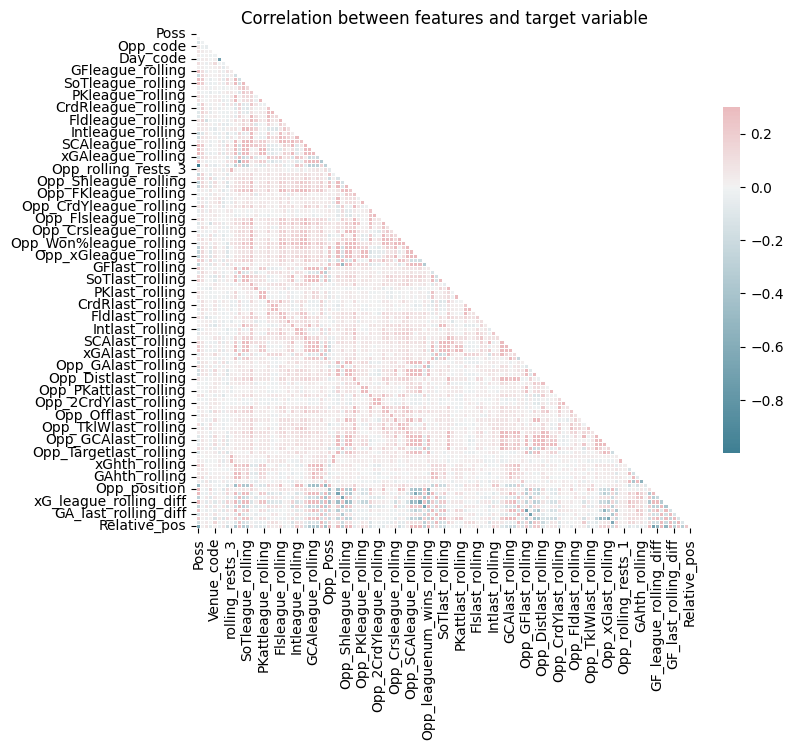

In [133]:
import seaborn as sns
import matplotlib.pyplot as plt
train = past_matches[past_matches['Season'] <= SEASON_SPLIT]
data = train.drop(columns=['Date'])

# compute the correlation matrix
corr_mat = data.corr()

# mask out upper triangle (correlation matrices are symmetric)
mask = np.zeros_like(corr_mat, dtype=bool)
mask[np.triu_indices_from(mask)] = True


f, ax = plt.subplots(figsize=(8, 9))
# generate custom colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)   
sns.heatmap(corr_mat, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation between features and target variable')
plt.show()

In [134]:
corr = data.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
to_drop


['PKattleague_rolling',
 'SCAleague_rolling',
 'GCAleague_rolling',
 'Opp_Poss',
 'Opp_PKattleague_rolling',
 'Opp_SCAleague_rolling',
 'Opp_GCAleague_rolling',
 'PKattlast_rolling']

## Creating models and training

In [135]:
predictors = ['Team_code', 'Opp_code', 'Venue_code', 'Hour', 'Day_code',
              'Team_position', 'Opp_position']
additional_predictors = ['rolling_rests_1', 'rolling_rests_3',
                           'leaguenum_wins_rolling']
predictors = predictors + league_ravg_new_cols + last_ravg_new_cols + hth_ravg_new_cols + additional_predictors
predictors = predictors + ['Opp_' + column for column in league_ravg_new_cols]
predictors = predictors + ['Opp_' + column for column in last_ravg_new_cols]
predictors = predictors + ['Opp_' + column for column in additional_predictors]
predictors = predictors + ['GF_league_rolling_diff', 'GA_league_rolling_diff',
                           'xG_league_rolling_diff', 'xGA_league_rolling_diff',
                           'GF_last_rolling_diff', 'GA_last_rolling_diff',
                           'xG_last_rolling_diff', 'xGA_last_rolling_diff',
                           'Relative_pos', 'hthnum_wins_rolling']

train = past_matches[past_matches['Season'] <= SEASON_SPLIT]
val = train[train['Date'] >= '2024-03-14']
train = train[train['Date'] < '2024-03-14']
test = past_matches[past_matches['Season'] > SEASON_SPLIT]
train_X = train[predictors]
val_X = val[predictors]
test_X = test[predictors]
train_Y = train['Target']
val_Y = val['Target']
test_Y = test['Target']

In [137]:
rf_model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': np.arange(100, 200, 5), 
    'min_samples_split': np.arange(2,10),
    'max_depth': np.arange(2,10)
}

tscv = TimeSeriesSplit(n_splits=5)

clf = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='accuracy', n_jobs=-1, cv=tscv)
clf.fit(train_X, train_Y)
refined_rf_model = clf.best_estimator_
preds = refined_rf_model.predict(test_X)
print(clf.best_params_)
print(classification_report(test_Y, preds, zero_division=0))

{'max_depth': np.int64(3), 'min_samples_split': np.int64(9), 'n_estimators': np.int64(105)}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        99
         1.0       0.53      0.55      0.54       152
         2.0       0.48      0.76      0.59       159

    accuracy                           0.50       410
   macro avg       0.34      0.44      0.37       410
weighted avg       0.38      0.50      0.43       410



In [138]:
feature_importance = pd.Series(refined_rf_model.feature_importances_, index=train_X.columns).sort_values(ascending=False)
feature_importance

Relative_pos              0.061504
xG_league_rolling_diff    0.060822
Opp_position              0.052486
Team_position             0.049186
Venue_code                0.038212
                            ...   
Opp_PKleague_rolling      0.000000
Opp_GAlast_rolling        0.000000
Opp_CrdRlast_rolling      0.000000
Opp_2CrdYlast_rolling     0.000000
Opp_PKattlast_rolling     0.000000
Length: 117, dtype: float64

In [139]:
THRESHOLD = 0.01
selected_features = feature_importance[feature_importance >= THRESHOLD].index
print(len(selected_features))
train_X_selected = train_X[selected_features]
test_X_selected = test_X[selected_features]

30


In [140]:
from sklearn.inspection import permutation_importance
result = permutation_importance(refined_rf_model, val_X, val_Y, n_repeats=10, random_state=42)

# Convert to DataFrame
importances_df = pd.DataFrame({
    "feature": val_X.columns,
    "importance_mean": result.importances_mean,
    "importance_std": result.importances_std
}).sort_values("importance_mean", ascending=False)

print(importances_df.head(10))

                    feature  importance_mean  importance_std
115            Relative_pos         0.015842        0.015466
5             Team_position         0.012871        0.006340
2                Venue_code         0.011881        0.009701
27         xGleague_rolling         0.010891        0.005332
1                  Opp_code         0.008911        0.002970
59     Opp_GFleague_rolling         0.008911        0.005332
101      Opp_xGlast_rolling         0.007921        0.003960
78    Opp_GCAleague_rolling         0.007921        0.005941
61     Opp_Shleague_rolling         0.004950        0.007982
108  GA_league_rolling_diff         0.003960        0.004850


In [55]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_X_selected)
test_X_scaled = scaler.fit_transform(test_X_selected)

In [78]:
rf_model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': np.arange(100, 200, 5), 
    'min_samples_split': np.arange(2,10),
    'max_depth': np.arange(2,10)
}

tscv = TimeSeriesSplit(n_splits=5)

clf = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='accuracy', n_jobs=-1, cv=tscv)
clf.fit(train_X_selected, train_Y)
refined_rf_model = clf.best_estimator_
preds = refined_rf_model.predict(test_X_selected)
print(clf.best_params_)
print(classification_report(test_Y, preds, zero_division=0))

{'max_depth': np.int64(5), 'min_samples_split': np.int64(7), 'n_estimators': np.int64(170)}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        99
         1.0       0.52      0.54      0.53       152
         2.0       0.46      0.74      0.57       159

    accuracy                           0.49       410
   macro avg       0.33      0.43      0.37       410
weighted avg       0.37      0.49      0.42       410



In [56]:
xgboost_model = XGBClassifier(random_state=42)
param_grid = {
    'eta': np.arange(0, 1, 0.1), 
    'max_depth': np.arange(1, 10),
    'alpha': np.arange(0, 10)
}

xgboost_clf = GridSearchCV(estimator=xgboost_model, param_grid=param_grid, scoring='accuracy', n_jobs=-1, cv=tscv)
xgboost_clf.fit(train_X_selected, train_Y)
refined_xgboost_model = xgboost_clf.best_estimator_
xgboost_preds = refined_xgboost_model.predict(test_X_selected)
print(xgboost_clf.best_params_)
print(classification_report(test_Y, xgboost_preds, zero_division=0))

{'alpha': np.int64(4), 'eta': np.float64(0.2), 'max_depth': np.int64(1)}
              precision    recall  f1-score   support

         0.0       0.50      0.01      0.02        99
         1.0       0.54      0.61      0.57       152
         2.0       0.48      0.70      0.57       159

    accuracy                           0.50       410
   macro avg       0.50      0.44      0.39       410
weighted avg       0.50      0.50      0.44       410



In [57]:
from sklearn.svm import SVC

svc_model = SVC(random_state=42, kernel='rbf')
param_grid = {
    'C': np.arange(0.1, 1, 0.1), 
    'gamma': ['scale','auto']
}

svc_clf = GridSearchCV(estimator=svc_model, param_grid=param_grid, scoring='accuracy', n_jobs=-1, cv=tscv)
svc_clf.fit(train_X_scaled, train_Y)
refined_svc_model = svc_clf.best_estimator_
svc_preds = refined_svc_model.predict(test_X_scaled)
print(svc_clf.best_params_)
print(classification_report(test_Y, svc_preds, zero_division=0))

{'C': np.float64(0.5), 'gamma': 'scale'}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        99
         1.0       0.51      0.61      0.56       152
         2.0       0.48      0.69      0.56       159

    accuracy                           0.49       410
   macro avg       0.33      0.43      0.37       410
weighted avg       0.37      0.49      0.42       410



In [58]:
lr_model = LogisticRegression(random_state=42, max_iter=20000)
param_grid = {
    'C': np.arange(0.1, 1, 0.1), 
    'solver': ['saga', 'lbfgs', 'sag', 'newton-cg', 'newton-cholesky']
}

lr_clf = GridSearchCV(estimator=lr_model, param_grid=param_grid, scoring='accuracy', n_jobs=-1, cv=tscv)
lr_clf.fit(train_X_scaled, train_Y)
refined_lr_model = lr_clf.best_estimator_
lr_preds = refined_lr_model.predict(test_X_scaled)
print(lr_clf.best_params_)
print(classification_report(test_Y, lr_preds, zero_division=0))

{'C': np.float64(0.1), 'solver': 'saga'}
              precision    recall  f1-score   support

         0.0       0.20      0.04      0.07        99
         1.0       0.51      0.59      0.55       152
         2.0       0.48      0.64      0.54       159

    accuracy                           0.48       410
   macro avg       0.39      0.42      0.39       410
weighted avg       0.42      0.48      0.43       410



In [94]:
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
normalized_sample_weights = compute_sample_weight('balanced', y=train_Y)
better_xgboost_model = XGBClassifier(alpha=2, random_state=42, eta=0.1, max_depth=1)
better_xgboost_model.fit(train_X_selected, train_Y, sample_weight = normalized_sample_weights)
better_xgboost_preds = better_xgboost_model.predict(test_X_selected)
print(classification_report(test_Y, better_xgboost_preds, zero_division=0))

              precision    recall  f1-score   support

         0.0       0.28      0.18      0.22       198
         1.0       0.52      0.58      0.55       311
         2.0       0.52      0.58      0.54       311

    accuracy                           0.48       820
   macro avg       0.44      0.44      0.44       820
weighted avg       0.46      0.48      0.47       820



In [95]:
better_svc_model = SVC(random_state=42, C=0.9, gamma='scale')
better_svc_model.fit(train_X_selected, train_Y, sample_weight=normalized_sample_weights)
better_svc_preds = better_svc_model.predict(test_X_selected)
print(classification_report(test_Y, better_svc_preds, zero_division=0))

              precision    recall  f1-score   support

         0.0       0.28      0.28      0.28       198
         1.0       0.52      0.52      0.52       311
         2.0       0.51      0.53      0.52       311

    accuracy                           0.46       820
   macro avg       0.44      0.44      0.44       820
weighted avg       0.46      0.46      0.46       820



In [96]:
better_lr_model = LogisticRegression(random_state=42, C=0.1, max_iter=2000, solver='sag')
better_lr_model.fit(train_X_selected, train_Y, sample_weight=normalized_sample_weights)
better_lr_preds = better_lr_model.predict(test_X_selected)
print(classification_report(test_Y, better_lr_preds, zero_division=0))

              precision    recall  f1-score   support

         0.0       0.25      0.26      0.26       198
         1.0       0.55      0.54      0.55       311
         2.0       0.54      0.55      0.55       311

    accuracy                           0.48       820
   macro avg       0.45      0.45      0.45       820
weighted avg       0.48      0.48      0.48       820



In [25]:
rf_model = RandomForestClassifier(random_state=42, n_estimators=145, min_samples_split=6)

rf_model.fit(train_X, train['Target'], sample_weight = normalized_sample_weights)
preds = rf_model.predict(test_X)
print(classification_report(test['Target'], preds, zero_division=0))

              precision    recall  f1-score   support

           0       0.36      0.09      0.14       196
           1       0.60      0.73      0.66       302
           2       0.59      0.75      0.66       302

    accuracy                           0.58       800
   macro avg       0.52      0.52      0.49       800
weighted avg       0.54      0.58      0.53       800



In [33]:
base_estimators = [
    ('rf', RandomForestClassifier(random_state=42, n_estimators=145, min_samples_split=6)),
    ('xgb', XGBClassifier(alpha=5, random_state=42, eta=0.2, max_depth=1))
    # ('lr', LogisticRegression(random_state=42, C=0.5, max_iter=2000))
]


voter = VotingClassifier(estimators=base_estimators, voting='soft')
# voter.fit(train_X, train['Target'])
# preds = voter.predict(test_X)
# print(classification_report(test['Target'], preds, zero_division=0))

param_grid = {
    'weights': [(w1, w2) for w1 in range(1,5) for w2 in range(1,5)]
}

voting_clf = GridSearchCV(estimator=voter, param_grid=param_grid, scoring='accuracy', n_jobs=-1, cv=tscv)
voting_clf.fit(train_X, train['Target'], sample_weight=normalized_sample_weights)
refined_voting_model = voting_clf.best_estimator_
voter_preds = refined_voting_model.predict(test_X)
print(voting_clf.best_params_)
print(classification_report(test['Target'], voter_preds, zero_division=0))

{'weights': (4, 1)}
              precision    recall  f1-score   support

           0       0.44      0.13      0.20       196
           1       0.61      0.74      0.67       302
           2       0.60      0.75      0.67       302

    accuracy                           0.59       800
   macro avg       0.55      0.54      0.51       800
weighted avg       0.57      0.59      0.55       800



{'weights': [1, 4]}
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       196
           1       0.59      0.79      0.68       302
           2       0.59      0.77      0.67       302

    accuracy                           0.59       800
   macro avg       0.40      0.52      0.45       800
weighted avg       0.45      0.59      0.51       800

In [36]:
preds_rf = refined_rf_model.predict_proba(test_X)
preds_xgb = better_xgboost_model.predict_proba(test_X)

# Compare predicted classes
corr = np.mean((preds_rf.argmax(axis=1) == preds_xgb.argmax(axis=1)))
print("Agreement between RF and XGB:", corr)

Agreement between RF and XGB: 0.6496815286624203


In [47]:
train_X.dtypes

Team_code         int64
Venue_code         int8
Opp_code          int64
Hour              int64
Day_code          int32
xG              float64
xGA             float64
GFrolling       float64
GArolling       float64
Shrolling       float64
SoTrolling      float64
Distrolling     float64
FKrolling       float64
PKrolling       float64
PKattrolling    float64
dtype: object

In [ ]:
# generate OOF predictions
def get_oof_predictions(model, X, y, cv):
    n_classes = len(np.unique(y))
    oof = np.zeros((len(X), n_classes))

    for train_idx, valid_idx in cv.split(X):
        X_tr, y_tr = X.iloc[train_idx], y.iloc[train_idx]
        X_val = X.iloc[valid_idx]

        model.fit(X_tr, y_tr)
        oof[valid_idx] = model.predict_proba(X_val)

    return oof

# Generate OOF features on TRAIN
oof_features = []
for name, model in base_estimators:
    oof_pred = get_oof_predictions(model, train_X, train['Target'], tscv)
    oof_features.append(oof_pred)
oof_features.append(train_X.values)
# Stack into meta-train
X_meta_train = np.hstack(oof_features)

# Train meta-learner
meta = LogisticRegression(max_iter=2000, random_state=42)
meta.fit(X_meta_train, train['Target'], sample_weight=normalized_sample_weights)

# Prepare TEST predictions
test_features = []
for name, model in base_estimators:
    # refit on full train
    model.fit(train_X, train['Target'])
    test_pred = model.predict_proba(test_X)
    test_features.append(test_pred)
test_features.append(test_X.values)

X_meta_test = np.hstack(test_features)

# Final stacked predictions
final_pred = meta.predict(X_meta_test)
final_pred_proba = meta.predict_proba(X_meta_test)
print(classification_report(test['Target'], final_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.36      0.31      0.34       196
           1       0.66      0.70      0.68       302
           2       0.66      0.69      0.67       302

    accuracy                           0.60       800
   macro avg       0.56      0.56      0.56       800
weighted avg       0.59      0.60      0.59       800



precision    recall  f1-score   support

           0       0.50      0.01      0.02       196
           1       0.60      0.78      0.68       302
           2       0.59      0.77      0.67       302

    accuracy                           0.59       800
   macro avg       0.56      0.52      0.46       800
weighted avg       0.57      0.59      0.51       800

## Predicting upcoming matches